### Surfs Up! The power of Python and SQLAlchemy
by Saloni Gupta

This notebook analysis climate of Honolulu, HI to plan a trip. The SQLAlchemy library in Python is used to simulate the access of a database of Honolulu, HI weather.

#### Dependencies
First, we need to load appropriate dependencies.

For example, we will use numpy for appropriate numeric methods, pandas for dataframes, and matplotlib.pyplot for plotting. We will use a color scheme based of FiveThirtyEight.com.

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

#### Create an engine

The Engine is the starting point for any SQLAlchemy application. We need to set up a connection to the database (hawaii.sqlite) to use SQLAlchemy.

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

#### Reflect the existing database into a new model

Now, we will reflect that database (set up the metadata of what tables we have).

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

#### Inspect Tables

We note that we have two tables, measurement and station. We will save classes of these to be able to reference the tables. Presumably, these correspond to actual weather measurements and information about specific stations.

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

#### Connect to Database

We now need to actually connect to the database by creating a session and binding the engine.

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

As we don't know how dates are formatted, we will inspect data first.

In [9]:
#Show each table's column names and type
inspector = inspect(engine)
measurement_columns = inspector.get_columns('measurement') # id,station,date,prcp,tobs
print (f'Columns from Measurement table\n--------------------------------------')
for c in measurement_columns:
    print(f'{c["name"]} | {c["type"]}')
print (f'--------------------------------------')    

station_columns = inspector.get_columns('station') # id,station,name,latitude,longitude,elevation
print (f'Columns from Station table\n--------------------------------------')
for c in station_columns:
    print(f'{c["name"]} | {c["type"]}')
print (f'--------------------------------------') 

conn = engine.connect()
Measurement_records = pd.read_sql("SELECT * FROM Measurement" , conn) 
                                  #where station = 'USC00519281' and date = '2017-08-18' 
print (f'Data in Measurement table\n--------------------------------------\n{Measurement_records.head(10)}')
print (f'--------------------------------------')  
Station_records = pd.read_sql("SELECT * FROM Station", conn)
print (f'Data in Station table\n--------------------------------------\n{Station_records.head(10)}')

Columns from Measurement table
--------------------------------------
id | INTEGER
station | TEXT
date | TEXT
prcp | FLOAT
tobs | FLOAT
--------------------------------------
Columns from Station table
--------------------------------------
id | INTEGER
station | TEXT
name | TEXT
latitude | FLOAT
longitude | FLOAT
elevation | FLOAT
--------------------------------------
Data in Measurement table
--------------------------------------
   id      station        date  prcp  tobs
0   1  USC00519397  2010-01-01  0.08  65.0
1   2  USC00519397  2010-01-02  0.00  63.0
2   3  USC00519397  2010-01-03  0.00  74.0
3   4  USC00519397  2010-01-04  0.00  76.0
4   5  USC00519397  2010-01-06   NaN  73.0
5   6  USC00519397  2010-01-07  0.06  70.0
6   7  USC00519397  2010-01-08  0.00  64.0
7   8  USC00519397  2010-01-09  0.00  68.0
8   9  USC00519397  2010-01-10  0.00  73.0
9  10  USC00519397  2010-01-11  0.01  64.0
--------------------------------------
Data in Station table
----------------------------

Here, we have Measurement table that has observations about precipitation and temperature for various dates. 
We also have a list of stations and their locations/elevations in Station table.

# Exploratory Climate Analysis

We will do some basic exploratory analysis of the data first.

#### Precipitation Analysis
First, we will look at precipitation data for the last year.

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Store last date from selected date range
latest_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
print (f'Last date in database: {latest_date}')

Last date in database: 2017-08-23


As we can see, the database stores data till August 23, 2017. So, we need to find precipitation data for same dates for last year i.e. from August 23, 2016 to August 23, 2017.

In the given date format, that is 2016-08-23 to 2017-08-23.

In [11]:
# Calculate the date 1 year ago from the last data point in the database
yr_ago = dt.datetime.strptime(latest_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Storing the year ago date in YYYY-MM-DD format for further analysis
query_date = yr_ago.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
prcp_one_yr = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date).\
order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(prcp_one_yr,columns = ['Date','Prcp'])
precipitation_df.set_index('Date', inplace=True)

# Sort the dataframe by date
sorted_prec_df=precipitation_df.sort_values(by=['Date'])
sorted_prec_df.head(10)

,Prcp
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
2016-08-23,1.79
2016-08-23,0.70
2016-08-24,1.45
2016-08-24,2.15


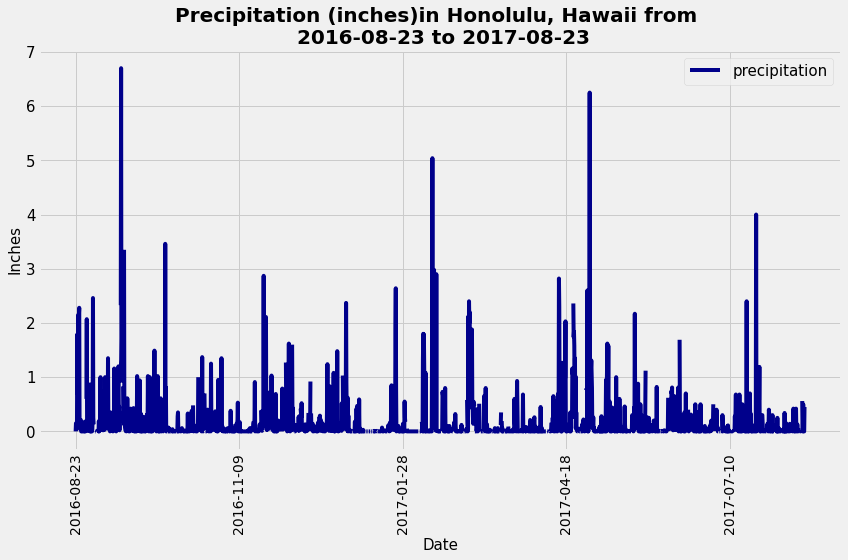

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data

# Set plot and plot the chart
fig,ax= plt.subplots(figsize=(12, 8))
sorted_prec_df.plot(ax= ax, x_compat = True, rot=90, color = 'darkblue')

# Add legend 
plt.legend(['precipitation'], loc="best",fontsize=15)

# Set Labels & Title
plt.xlabel('Date', fontsize=15)
plt.ylabel("Inches",fontsize=15)
plt.title(f"Precipitation (inches)in Honolulu, Hawaii from \n {query_date} to {latest_date}",fontsize=20, fontweight = 'bold')
plt.yticks(size=15)

# Save Figure
plt.savefig("Images/Precipitation_Plot.png", bbox_inches = 'tight')
plt.tight_layout()

# Show plot
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_prec_df.describe()

,Prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


Apparently,most observations are of very small precipitation amounts.

#### Station Analysis
We wish to investigate the actual stations now.

Starting with how many stations there are and what are the most active stations.

In [14]:
# Design a query to show how many stations are available in this dataset?
num_of_stations = session.query(Station.id).distinct().count()
print(f"Station Count: {num_of_stations}")

Station Count: 9


In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

stations_counts = session.query(Station.station, func.count(Measurement.station)).\
filter(Station.station == Measurement.station).group_by(Station.station).order_by(func.count(Measurement.station).desc()).all()

for result in stations_counts:
    print(f"Station: {result[0]}\tCount: {result[1]}")

Station: USC00519281	Count: 2772
Station: USC00519397	Count: 2724
Station: USC00513117	Count: 2709
Station: USC00519523	Count: 2669
Station: USC00516128	Count: 2612
Station: USC00514830	Count: 2202
Station: USC00511918	Count: 1979
Station: USC00517948	Count: 1372
Station: USC00518838	Count: 511


We wish to now analyse the temperature, and we will calculate the average, lowest, and highest temperature of the most active station as a first check.

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

most_active_station = stations_counts[0]
print (f'The most active station is: {most_active_station[0]}')

most_active_station_temp =session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), \
              func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station[0]).all()

print (f'The Min temp at the most active station {most_active_station[0]} is {most_active_station_temp[0][0]} F')
print (f'The Max temp at the most active station {most_active_station[0]} is {most_active_station_temp[0][1]} F')
print (f'The Avg temp at the most active station {most_active_station[0]} is {round(most_active_station_temp[0][2],2)} F')

The most active station is: USC00519281
The Min temp at the most active station USC00519281 is 54.0 F
The Max temp at the most active station USC00519281 is 85.0 F
The Avg temp at the most active station USC00519281 is 71.66 F


We will now find the temperatures for the final 12 months for the station with the most observations and plot the histogram.

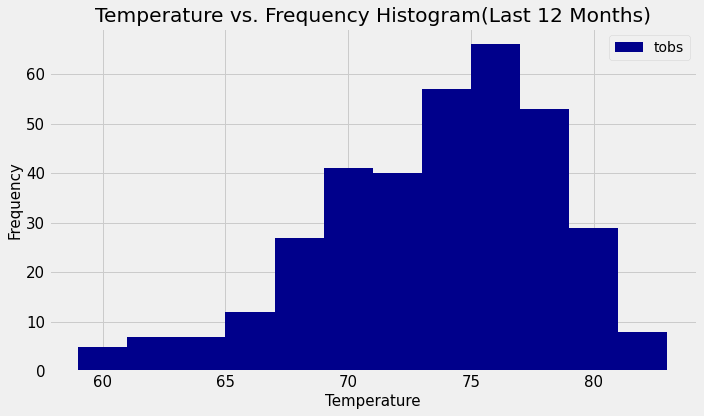

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_data = session.query(Measurement.tobs).\
    filter(Measurement.date >= query_date).\
    filter(Measurement.station == most_active_station[0]).\
    order_by(Measurement.date).all()

# Save the Query Results as a Pandas DataFrame
tobs_data_df = pd.DataFrame(tobs_data, columns=["tobs"])

# Plot the Results as a Histogram with `bins=12`
tobs_data_df.plot.hist(bins=12, title='Temperature vs. Frequency Histogram(Last 12 Months)', figsize=(10,6),color="darkblue")
plt.xlabel('Temperature',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.legend(loc="upper right")
plt.yticks(size=15)
plt.xticks(size=15)

#save figure
plt.tight_layout()
plt.savefig("Images/temp_vs_frequency.png")
plt.show()

We see the temperature is usually between 70 and 80 degrees Fahrenheit, which as expected in Hawaii.

## Bonus Challenge Assignment

#### Temperature Analysis I

In [28]:
# Identify the average temperature in June at all stations across all available years in the dataset. 
avg_june_temp = session.query(func.round(func.avg(Measurement.tobs))).\
                filter(func.strftime("%m", Measurement.date) == "06").filter(Measurement.tobs!=None).all()

average_june_temp = list(np.ravel(avg_june_temp))[0]

# Identify the average temperature in December at all stations across all available years in the dataset. 
avg_dec_temp = session.query(func.round(func.avg(Measurement.tobs))).\
                filter(func.strftime("%m", Measurement.date) == "12").filter(Measurement.tobs!=None).all()

average_dec_temp = list(np.ravel(avg_dec_temp))[0]

print(f"The average temperature in June at all stations across all available years in the dataset is {average_june_temp} F.")
print(f"The average temperature in December at all stations across all available years in the dataset is {average_dec_temp} F.")

The average temperature in June at all stations across all available years in the dataset is 75.0 F.
The average temperature in December at all stations across all available years in the dataset is 71.0 F.


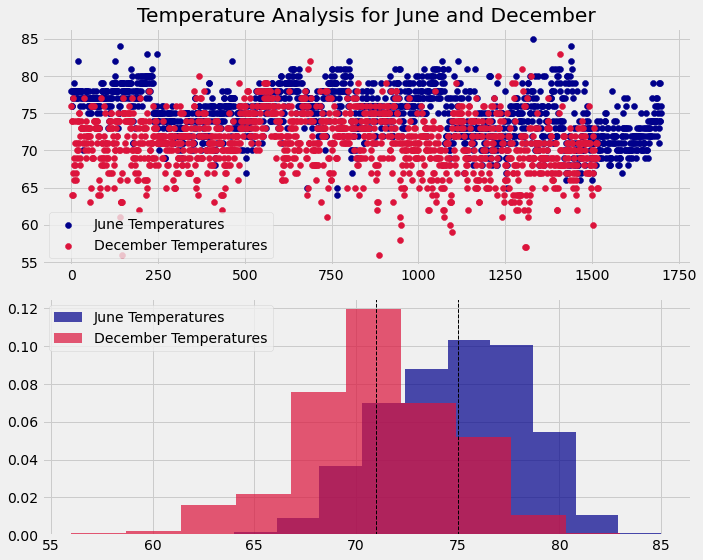

In [59]:
june_temp = session.query(Measurement.tobs).\
                filter(func.strftime("%m", Measurement.date) == "06").filter(Measurement.tobs != None).all()
june_temp_list = list(np.ravel(june_temp))
dec_temp = session.query(Measurement.tobs).\
                filter(func.strftime("%m", Measurement.date) == "12").filter(Measurement.tobs != None).all()
dec_temp_list = list(np.ravel(dec_temp))

# Scatter Plot of Data
plt.figure(figsize=(10,8))
plt.subplot(2, 1, 1)
plt.title("Temperature Analysis for June and December")
plt.scatter(range(len(june_temp_list)),june_temp_list, label="June Temperatures",color = 'darkblue')
plt.scatter(range(len(dec_temp_list)),dec_temp_list, label="December Temperatures",color='crimson')
plt.legend()

# Histogram Plot of Data
plt.subplot(2,1,2)
plt.hist(june_temp_list, 10, density=True, alpha=0.7, label="June Temperatures", color='darkblue')
plt.hist(dec_temp_list, 10, density=True, alpha=0.7, label="December Temperatures",color='crimson')
plt.axvline(average_june_temp, color='k', linestyle='dashed', linewidth=1)
plt.axvline(average_dec_temp, color='k', linestyle='dashed', linewidth=1)
plt.legend(loc = "best")
plt.tight_layout()
plt.savefig("Images/june_dec_scatterplot_histogram.png")

#### Unpaired t-tests
Used Unpaired t-tests to compare the means of two populations (June and December temperatures in Hawaii). The reason being unpaired t-tests are used to compare the means of two independent populations which I think is more relevant in this case. 
However, a paired t-test (one sample t-test) looks at average of two related groups to determine if there is a significant difference between the two groups.

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


#### Temperature Analysis for Trip

#### Trip Dates
We wish to perform a temperature analysis for a trip where we need to pick our trip dates. We are planning for March 2018 trip time, assuming that temperature is moderate during that time. So, we will go on March 14, 2018 and return on March 28, 2018. As we only have data until 2017, we will query and analyse data for 2017-03-14 to 2017-03-28.

In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# applying the calc_temps function to our trip time.
trip_start_date = '2018-03-14'
trip_end_date = '2018-03-28'

#calculated trip start and end date for previous year by subtracting 365 days from planned trip start and end date
trip_start_prev = dt.datetime.strptime(trip_start_date, '%Y-%m-%d') - dt.timedelta(days=365)
trip_end_prev = dt.datetime.strptime(trip_end_date, '%Y-%m-%d') - dt.timedelta(days=365)
my_trip = calc_temps(trip_start_prev, trip_end_prev) #("2017-03-14", "2017-03-28")

print(f"Min Temp estimated during vacation: {my_trip[0][0]} F")
print(f"Avg Temp estimated during vacation: {round(my_trip[0][1], 2)} F")
print(f"Max Temp estimated during vacation: {my_trip[0][2]} F")

Min Temp estimated during vacation: 65.0 F
Avg Temp estimated during vacation: 73.18 F
Max Temp estimated during vacation: 80.0 F


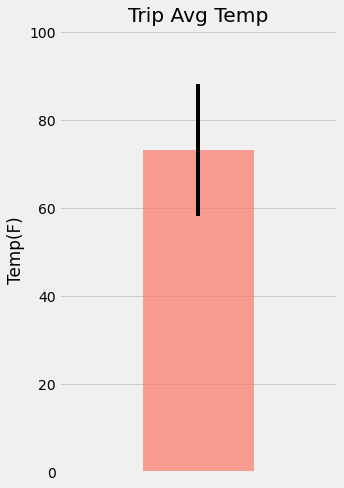

In [22]:
# Plot the min, avg, and max Temperatures from the Previous Query as a Bar Chart

my_trip_df = pd.DataFrame(my_trip, columns=["TMIN", "TAVG", "TMAX"])

# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
yerr = my_trip_df["TMAX"] - my_trip_df["TMIN"]

# Use the Average Temperature for the y Value
my_trip_df.plot.bar(y="TAVG",yerr=yerr, color='salmon', alpha=0.75, align='center',figsize=(5,7), legend = None, width = 0.8)

# Use "Trip Avg Temp" as your Title
plt.title('Trip Avg Temp')

# Plot the results from your previous query as a bar chart. 
plt.ylabel('Temp(F)')
plt.ylim(0,101)
plt.xlim(-1,1)
plt.xticks([])
plt.tight_layout()
plt.savefig("Images/trip_avg_temp.png")
plt.show()

#### Rainfall per Weather Station
We wish to investigate the total amount of rainfall at each station in the last year.

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

#query for precipitation per station on trip dates
sel = ([Station.station, 
        Station.name, 
        func.sum(Measurement.prcp), 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
       ])

stationRain = (session.query(*sel)
                   .filter(Station.station == Measurement.station) \
                   .filter(Measurement.date.between(trip_start_prev,trip_end_prev)) \
                   .group_by(Station.station) \
                   .order_by(func.sum(Measurement.prcp).desc()) \
                   .all())
#convert query object to data frame
rain_trip_db = pd.DataFrame(stationRain, columns = ['Station','Name','Total Precipitation', 'Latitude', 'Longitude', 'Elevation'])
rain_trip_db

,Station,Name,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",1.36,21.33310,-157.80250,152.4
1,USC00519281,"WAIHEE 837.5, HI US",1.35,21.45167,-157.84889,32.9
2,USC00513117,"KANEOHE 838.1, HI US",0.95,21.42340,-157.80150,14.6
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.87,21.33556,-157.71139,19.5
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.21,21.52130,-157.83740,7.0
5,USC00519397,"WAIKIKI 717.2, HI US",0.02,21.27160,-157.81680,3.0
6,USC00517948,"PEARL CITY, HI US",0.00,21.39340,-157.97510,11.9


#### Daily Normal Tempeartures for Trip

We wish to calculate the daily normal temperatures (averages for minimum, maximum, and mean temperatures) for our trip from Mar 14 to Mar 28.

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

#set the start and end date for the trip
trip_start_date = '2018-03-14'
trip_end_date = '2018-03-28'

# Use the start and end date to create a range of dates
startNum = int(trip_start_date[-2:])
endNum = int(trip_end_date[-2:])

#calculate trip length
tripLength = endNum - startNum + 1

#start date as datetime object
trip_start_date = dt.datetime.strptime(trip_start_date, '%Y-%m-%d')

# Stip off the year and save a list of %m-%d strings
datelist = [dt.datetime.strftime(trip_start_date + dt.timedelta(days = x), '%m-%d') 
            for x in range(0, tripLength)]
datelist

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []

for date in datelist:
    normals.append(daily_normals(date))
    
print(f"Chosen Dates: March {startNum} to March {endNum} ({tripLength} day trip)")
for normal in normals:
    print(normal)


Chosen Dates: March 14 to March 28 (15 day trip)
[(62.0, 70.32758620689656, 77.0)]
[(58.0, 68.54716981132076, 76.0)]
[(60.0, 69.70370370370371, 78.0)]
[(57.0, 68.54, 75.0)]
[(57.0, 67.7843137254902, 76.0)]
[(60.0, 69.1, 75.0)]
[(62.0, 70.11764705882354, 80.0)]
[(60.0, 71.07692307692308, 77.0)]
[(65.0, 71.75471698113208, 77.0)]
[(63.0, 70.79629629629629, 78.0)]
[(62.0, 71.5, 77.0)]
[(63.0, 71.5, 78.0)]
[(64.0, 71.38, 80.0)]
[(63.0, 71.53846153846153, 80.0)]
[(59.0, 71.51785714285714, 82.0)]


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

#extract normals into a list of lists
tripNormals = [np.array(normal[0]) for normal in normals]

#load into a data frame
trip_normals_df = pd.DataFrame(tripNormals, columns = ["tmin","avg","tmax"])

#find daterange from trip start date and trip length
trip_dates = pd.date_range(trip_start_date, periods=tripLength).tolist()

#set index as Date (convert from Tmestamp to YYYY-MM-DD format)
trip_normals_df.index = [(date.strftime('%Y-%m-%d')) for date in trip_dates]

#display
trip_normals_df

,tmin,avg,tmax
2018-03-14,62.0,70.327586,77.0
2018-03-15,58.0,68.547170,76.0
2018-03-16,60.0,69.703704,78.0
2018-03-17,57.0,68.540000,75.0
2018-03-18,57.0,67.784314,76.0
2018-03-19,60.0,69.100000,75.0
2018-03-20,62.0,70.117647,80.0
2018-03-21,60.0,71.076923,77.0
2018-03-22,65.0,71.754717,77.0
2018-03-23,63.0,70.796296,78.0


Plot this data as an area plot.

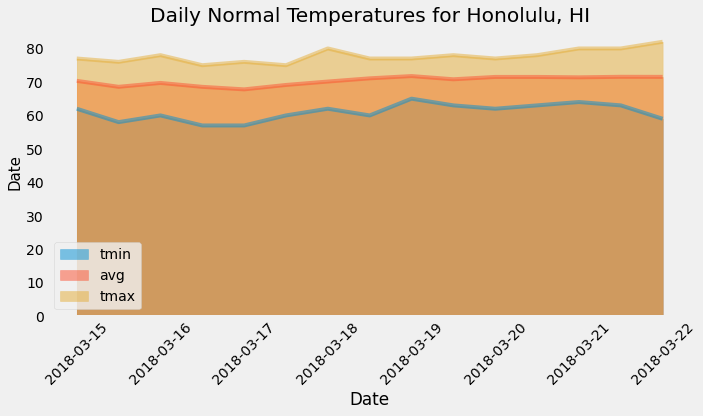

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
fig, ax = plt.subplots(figsize = (10, 6))
trip_normals_df.plot.area(ax = ax, stacked = False)

#set labels
ax.set_xlabel('Date')
ax.set_ylabel('Temperature (Fahrenheit)')
ax.set_title('Daily Normal Temperatures for Honolulu, HI')

#set ticks
plt.ylabel("Date",fontsize=15)

#ax.set_xticks(np.arange(len(dates)))
ax.set_xticklabels(trip_normals_df.index, rotation = 45)

#save figure
plt.savefig('Images/dailynormarea.png')

#show
plt.grid()
plt.tight_layout()
plt.show()